# Utilización, procesamiento y visualización de grandes volúmenes de datos

Imanol Muñiz Ramirez A01701713

## Cambios realizados después de la retroalimentación
* Se justificaron más ampliamente las acciones llevadas a cabo
* Se explicaron más ampliamente las observaciones del proceso
* Se eliminaron prints innecesarios
* Se verificó el código y se simplificó
* Se añadieron más gráficos para una mejor comprensión de la situación y los resultados.
* Se deversificaron los gráficos utilizados

## Objetivo

Obtener un modelo de procesamiento del lenguaje natural que sea capaz de clasificar artículos cortos por su tema utilizando PySpark para el manejo de los datos y ML como framework de creación de modelos.

## Contexto

Para este proyecto seleccionamos dos datasets. El primero de ellos es WikiCAT_dataseset https://huggingface.co/datasets/PlanTL-GOB-ES/WikiCAT_esv2?utm_source=chatgpt.com y CC-NEWS-ES https://huggingface.co/datasets/LeoCordoba/CC-NEWS-ES?utm_source=chatgpt.com. WikiCAT Contiene artículos cortos categorizados en 12 temas distintos. Está separado en trainning y validación sumando en total 8.71 MB. CC-NEWS contiene artículos de distintos países sumando en total 7.62 GB de datos. Usarémos el primer conjunto de datos para entrenar al modelo y posteriormente harémos las predcciones del dataset de CC-NEWS.

## Creamos la sesión de Spark

Primero creamos la sesión de Spark con la que trabajaremos los datos. Añadimos las configuraciones adicionales para proporcionar mayor rendimiento de acuerdo al hardware con el que contamos.

In [1]:
import json
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, monotonically_increasing_id

os.environ["HADOOP_HOME"] = "C:\\hadoop"
os.environ["PATH"] += ";C:\\hadoop\\bin"

# 💡 Desactiva el uso de librerías nativas (previene el error UnsatisfiedLinkError)
os.environ["HADOOP_OPTIONAL_TOOLS"] = "hadoop-azure"
os.environ["JAVA_TOOL_OPTIONS"] = "-Djava.library.path=C:\\hadoop\\bin"
os.environ["HADOOP_OPTS"] = "-Djava.library.path=C:\\hadoop\\bin"
os.environ["HADOOP_USER_NAME"] = "hadoop"

spark = SparkSession.builder \
    .master("local[*]") \
    .appName("BR JSON Reader") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.default.parallelism", "8") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .config("spark.hadoop.hadoop.home.dir", "C:\\hadoop") \
    .config("spark.hadoop.home.dir", "C:\\hadoop") \
    .config("spark.hadoop.io.nativeio.native", "false") \
    .config("spark.hadoop.native.io.enable", "false") \
    .getOrCreate()

## Pasamos los datos de WikiCAT de JSON a formato CSV

Actualmente los datos de este dataset están en un formato JSON dónde los datos vienen en atributo "data" que es un arreglo de objetos que contiene la oración y la etiqueta:

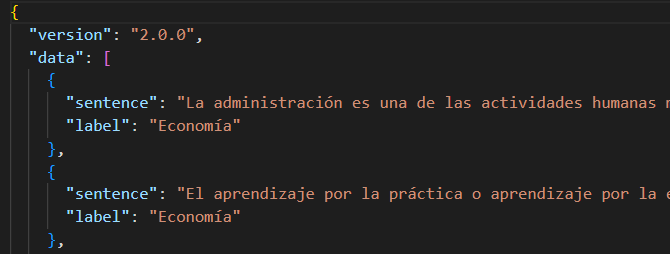

Por lo que para poder generar más fácilmente los dataframes de PySpark vamos a convertir los archivos a csv con las columnas id, label y sentence.

In [2]:
import csv

# Ruta del archivo JSON
json_files = []
json_files.append(r"D:\Tec\Septimo\Cloud\Global Superstore Analysis\hftrain_esv5.json")
json_files.append(r"D:\Tec\Septimo\Cloud\Global Superstore Analysis\hfeval_esv5.json")

for json_file in json_files:
    with open(json_file, 'r', encoding='utf-8') as f:
        json_data = json.load(f)

    data_array = json_data['data']
    output_dir = "WikiCAT_dataset"
    os.makedirs(output_dir, exist_ok=True)

    if json_file.endswith("hftrain_esv5.json"):
        csv_file = f"{output_dir}/train_esv5.csv"
    else:
        csv_file = f"{output_dir}/valid_esv5.csv"

    with open(csv_file, 'w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
        writer.writerow(['id', 'label', 'sentence'])
        
        # Escribir datos
        for idx, row in enumerate(data_array):
            sentence = row['sentence'].replace('\n', ' ').replace('\r', ' ')
            writer.writerow([idx, row['label'], sentence])

    print(f"✓ Dataset guardado exitosamente en {csv_file}")
    print(f"  Total de filas escritas: {len(data_array)}")

✓ Dataset guardado exitosamente en WikiCAT_dataset/train_esv5.csv
  Total de filas escritas: 6716
✓ Dataset guardado exitosamente en WikiCAT_dataset/valid_esv5.csv
  Total de filas escritas: 1685


## Obtenemos la información del CSV de WikiCAT 

Revisamos que se haya almacenado correctamente e imprimimos información útil para elaborar nuestro tablero de visualización

In [3]:
df_wikicat = spark.read.csv(
    r"D:\Tec\Septimo\Cloud\Global Superstore Analysis\WikiCAT_dataset\train_esv5.csv",
    header=True,
    inferSchema=True,
    encoding="UTF-8"
)

print("\nDistribución de etiquetas:")
df_wikicat.groupBy("label").count().orderBy("count", ascending=False).show()


Distribución de etiquetas:
+--------------------+-----+
|               label|count|
+--------------------+-----+
|            Política| 1230|
|Ciencia_y_Tecnología|  996|
|            Economía|  726|
|         Matemáticas|  613|
|             Derecho|  540|
|              Música|  528|
|         Humanidades|  520|
|            Historia|  396|
|           Filosofía|  378|
|             Deporte|  324|
|            Religión|  301|
|     Entretenimiento|  164|
+--------------------+-----+

+--------------------+-----+
|               label|count|
+--------------------+-----+
|            Política| 1230|
|Ciencia_y_Tecnología|  996|
|            Economía|  726|
|         Matemáticas|  613|
|             Derecho|  540|
|              Música|  528|
|         Humanidades|  520|
|            Historia|  396|
|           Filosofía|  378|
|             Deporte|  324|
|            Religión|  301|
|     Entretenimiento|  164|
+--------------------+-----+



La distribución de los datos es la siguiente:

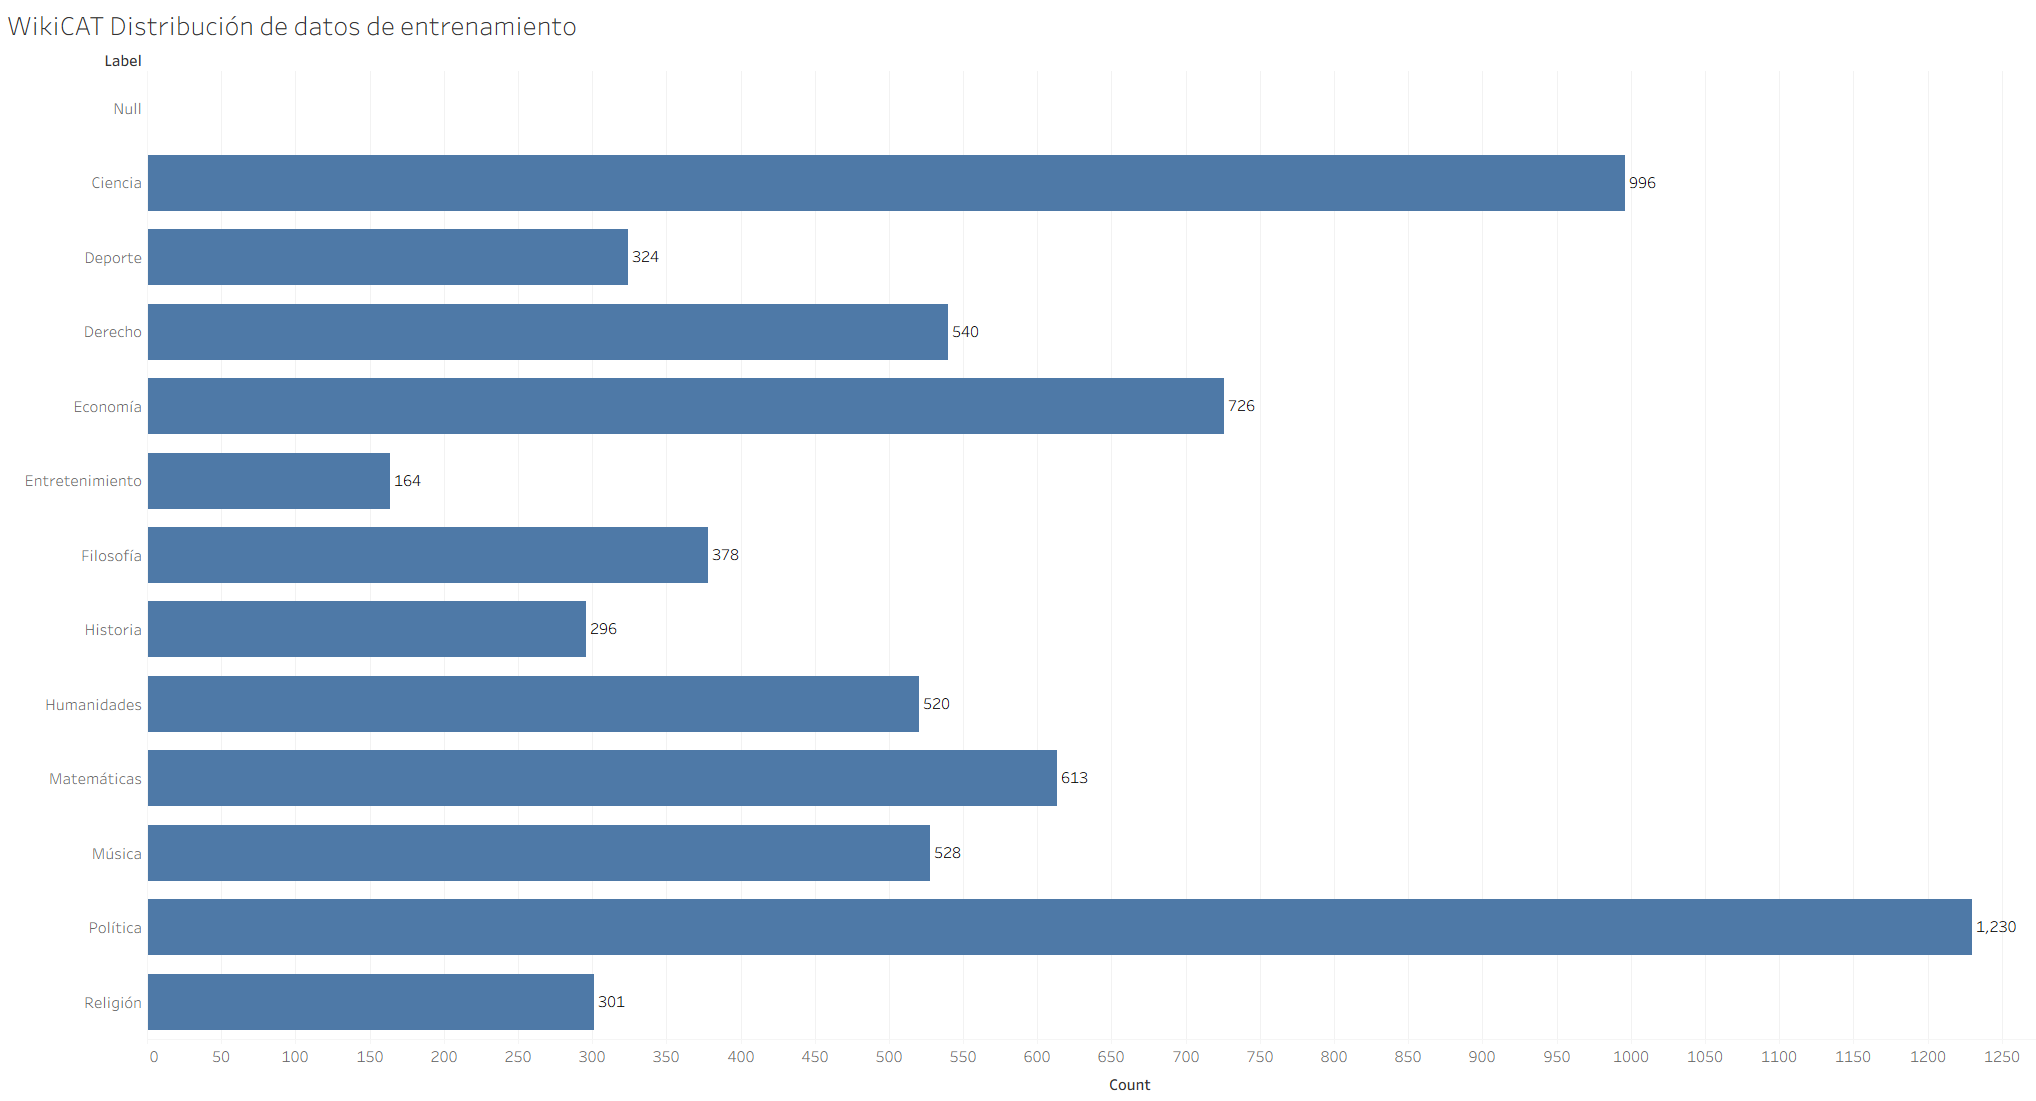

Podemos observar que es un conjunto de datos desbalanceado. Esto hay que tenerlo presente porque es posible que derive en problemas de desbalance por lo que dependiendo de los resultados del modelo podría ser necesario aplicar una técnica de regularización.

## Preparación de los datos del modelo

Posteriormente requerimos hacer algunas adecuaciones a los datos: Primero definimos el nombre de las columnas en el dataframe para que coincida más adelante con el del dataset de CC-NEWS-ES. Luego estándarizamos los textos quitando las mayúsculas y cambiando las tabulaciones, saltos de linea y espacios por ' ', adicionalmente los limpiamos filtrando aquellos registros que estén vacíos o muy cortos. Esto ayuda a procesar los textos más eficientemente cuando no es importante comprender la puntuación de las oraciones.

In [4]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, StringIndexer, NGram, VectorAssembler
from pyspark.sql.functions import length, col, lower, trim, regexp_replace

df_valid = spark.read.csv(
    r"D:\Tec\Septimo\Cloud\Global Superstore Analysis\WikiCAT_dataset\valid_esv5.csv",
    header=True,
    inferSchema=True,
    encoding="UTF-8"
)

df_train = df_wikicat.withColumnRenamed("sentence", "texto") \
                     .withColumnRenamed("label", "tema")

df_test = df_valid.withColumnRenamed("sentence", "texto") \
                  .withColumnRenamed("label", "tema")

def clean_data(df):
    df = df.withColumn("texto", lower(col("texto")))
    df = df.withColumn("texto", trim(col("texto")))
    df = df.withColumn("texto", regexp_replace(col("texto"), r'\s+', ' '))  # Normalizar espacios
    
    df = df.filter(col("texto").isNotNull())
    df = df.filter(col("texto") != "")
    df = df.filter(length(col("texto")) > 20)
    df = df.filter(col("tema").isNotNull())
    
    return df

train_data = clean_data(df_train)
test_data = clean_data(df_test)

Después creamos el pipeline a los que se someterán nuestros dataframes para tokenizar y convertir a vectores las palabras de las oraciones.
* Primero utilizamos RegexTokenizer para definir cuáles serán nuestros tokens. Para este trabajo vamos a utilizar el patrón \W que divide las oraciones en palabras separadas por simbolos de puntuación como espacios, comas, puntos y otros símbolos de pregutnas, exclamaciones, guiones etc. Adicionalmente definimos minTokenLength=3 para indicar que no queremos asignar token a palabras de 3 letras o menos como "a", "de", "les", "y" etc. Esto lo hacemos debido a que generalmente estas palabras no aportan significado al tema del texto por lo que así eficientamos y quitamos ruido al proceso.
* Con el mismo objetivo del punto anterior ahora utilziamos StopWordsRemover que nos elimina aquellas palabras que no aportan significado a la oración pero que pueden contener más de 3 letras, por ejemplo "como", "pero" etc.
* Posteriormente usamos CountVectorizer para contar las palabrás únicas entre todos los registros de nuestro dataset. Tomamos únicamente las 10,000 más frecuentes y las que aparezcan al menos en 2 oraciones.
* Luego, utilizamos IDF para calcular para calcular que tan importante son las palabras para predecir el tema del texto, si una palabra está en todos los textos se le asigna un peso pequeño, si tiene pocas apariciones puede ser que sea importante para el análisis. Únicamente aplicamos este peso a aquellas palabras que tengan al menos 2 apariciones en distintos textos. Esto evita que las palabras que aparezcan en un solo texto, tengan demasiado peso en la predicción.
* Finalmente usamos StringIndexer para convertir las etiquetas en valores númericos. 

In [5]:
tokenizer = RegexTokenizer(
    inputCol="texto", 
    outputCol="palabras", 
    pattern="\\W",
    minTokenLength=3
)

remover = StopWordsRemover(
    inputCol="palabras", 
    outputCol="palabras_limpias", 
    stopWords=StopWordsRemover.loadDefaultStopWords("spanish")
)

cv = CountVectorizer(
    inputCol="palabras_limpias", 
    outputCol="rawFeatures", 
    vocabSize=10000,  
    minDF=2.0 
)

idf = IDF(
    inputCol="rawFeatures", 
    outputCol="features", 
    minDocFreq=2
)

indexer = StringIndexer(
    inputCol="tema", 
    outputCol="label",
    handleInvalid="keep"
)

preprocessing_pipeline = Pipeline(stages=[tokenizer, remover, cv, idf, indexer])

Una vez que tenemos el pipeline definido podemos alimentar al modelo con los datos listos y transformamos los textos a secuencias de vectores con preprocessing_model.transform(train_data). Todo está listo para empezar el entrenamiento del modelo.

In [6]:
preprocessing_model = preprocessing_pipeline.fit(train_data)

train_processed = preprocessing_model.transform(train_data)
test_processed = preprocessing_model.transform(test_data)

# Cachear para mejorar rendimiento
train_processed.cache()
test_processed.cache()

# Forzar evaluación
train_count = train_processed.count()
test_count = test_processed.count()

print(f"\nDatos de entrenamiento procesados: {train_count} registros")
print(f"Datos de prueba procesados: {test_count} registros\n")



Datos de entrenamiento procesados: 6716 registros
Datos de prueba procesados: 1685 registros



In [7]:
print(train_processed.columns)
print(train_processed.select("features").show(1, truncate=False))

['id', 'tema', 'texto', 'palabras', 'palabras_limpias', 'rawFeatures', 'features', 'label']
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Entrenamos el modelo

Usamos el framework de ML para configurar un modelo de regresión logística que clasifique las secuencias de vectores generados en el preprocesamiento del conjunto de train y probamos el desempeño con los datos de evaluación. Imprimimos el resumen de los resultados generales y guardamos los resultados por clase en un csv, el modelo de preprocesamiento y el de predicción.

* featuresCol: indica las variables independientes, en nuestro caso las secuencias de vectores.
* labelCol: indica la columna con las variables objetivo, en este caso el índice de los temas de los textos.
* maxIter: número de épocas
* regParam: Coeficiente de regularización. Controla la penalización aplicada a los pesos del modelo para evitar overfitting. Valores más altos penalizan más
* elasticNetParam: penalización L1, L2. 
* tol: Detiene el entrenamiento cuando las mejoras son muy pequeñas
* standarization: normaliza los valores de los vectores
* family: indica la función de perdida multinomial, cross entropy en este caso.


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import when, col

modelo_clasificacion = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=100,         
    regParam=0.001,       
    elasticNetParam=0.1,  
    tol=1e-6,             
    standardization=True, 
    family="multinomial"  
)

modelo_entrenado = modelo_clasificacion.fit(train_processed)
# Obtener predicciones sobre el conjunto de prueba
predictions = modelo_entrenado.transform(test_processed)

# Cachear predicciones
predictions.cache()
pred_count = predictions.count()

evaluator_accuracy = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="accuracy"
)
accuracy = evaluator_accuracy.evaluate(predictions)

evaluator_f1 = MulticlassClassificationEvaluator(
    labelCol="label", 
    predictionCol="prediction", 
    metricName="f1"
)
f1_score = evaluator_f1.evaluate(predictions)

print(f"MÉTRICAS DE EVALUACIÓN:")
print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"✓ F1 Score: {f1_score:.4f} ({f1_score*100:.2f}%)")

# Contar predicciones correctas e incorrectas
predictions_analysis = predictions.withColumn(
    "correcto",
    when(col("label") == col("prediction"), 1).otherwise(0)
)

total_correct = predictions_analysis.filter(col("correcto") == 1).count()
total_incorrect = predictions_analysis.filter(col("correcto") == 0).count()

print(f"Predicciones correctas:   {total_correct:,} ({total_correct/pred_count*100:.2f}%)")
print(f"Predicciones incorrectas: {total_incorrect:,} ({total_incorrect/pred_count*100:.2f}%)")

# Análisis por tema

tema_stats = predictions_analysis.groupBy("tema").agg(
    {"correcto": "sum", "tema": "count"}
).withColumnRenamed("sum(correcto)", "correctos") \
 .withColumnRenamed("count(tema)", "total")

tema_stats = tema_stats.withColumn(
    "accuracy_tema",
    (col("correctos") / col("total") * 100)
)

# Guardar estadísticas de performance por tema en CSV
tema_stats_ordenado = tema_stats.orderBy(col("accuracy_tema").desc())
temp_stats_dir = "temp_tema_stats"
tema_stats_ordenado.coalesce(1).write.mode("overwrite").option("header", "true").csv(temp_stats_dir)

# Mover el archivo CSV al nombre deseado
import glob
import shutil
csv_parts = glob.glob(f"{temp_stats_dir}/*.csv")
if csv_parts:
    stats_csv_file = "performance_por_tema.csv"
    shutil.move(csv_parts[0], stats_csv_file)
    shutil.rmtree(temp_stats_dir)

# Guardar el modelo completo
try:
    preprocessing_model.write().overwrite().save("modelo_preprocessing_wikicat_mejorado")
    modelo_entrenado.write().overwrite().save("modelo_clasificacion_wikicat_mejorado")
    
    # Guardar mapeo de etiquetas
    import pickle
    label_to_tema = dict(
        zip(
            preprocessing_model.stages[-1].labels,
            range(len(preprocessing_model.stages[-1].labels))
        )
    )
    with open("label_to_tema_mapping.pkl", "wb") as f:
        pickle.dump(label_to_tema, f)
    
    metricas = {
        "accuracy": accuracy,
        "f1_score": f1_score,
    }
    
except Exception as e:
    print(f"⚠ Error al guardar: {e}")


print(f"ACCURACY: {accuracy*100:.2f}%")
print(f"F1 SCORE: {f1_score*100:.2f}%")


MÉTRICAS DE EVALUACIÓN:
Accuracy: 0.6421 (64.21%)
✓ F1 Score: 0.6409 (64.09%)
Predicciones correctas:   1,082 (64.21%)
Predicciones incorrectas: 603 (35.79%)
ACCURACY: 64.21%
F1 SCORE: 64.09%
ACCURACY: 64.21%
F1 SCORE: 64.09%


Para ver el comportamiento del entrenamiento extraemos los datos historicos de la función de perdida y los exportamos a un csv para en Tableu generar el gráfico. 

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import math

objective_history = None
try:
    objective_history = modelo_entrenado.summary.objectiveHistory
except Exception:
    objective_history = None
    print("\nNo se encontró 'objectiveHistory' en el resumen del modelo.")

try:
    preds_pd_loss = predictions.select('probability', 'label').toPandas()
    def _row_logloss(prob_vec, label):
        try:
            pv = list(prob_vec)
            prob = float(pv[int(label)])
            prob = max(min(prob, 1.0 - 1e-15), 1e-15)
            return -math.log(prob)
        except Exception:
            return float(0.0)

    preds_pd_loss['logloss'] = preds_pd_loss.apply(lambda r: _row_logloss(r['probability'], r['label']), axis=1)
    test_logloss = float(preds_pd_loss['logloss'].mean())
except Exception as e:
    print(f"Error calculando logloss en pandas: {e}")
    test_logloss = None

df_loss = pd.DataFrame()
df_loss['train_loss'] = objective_history
df_loss['test_loss'] = test_logloss
df_loss['iteration'] = range(1, len(objective_history) + 1)
df_loss.to_csv("training_vs_test_loss.csv", index=False)




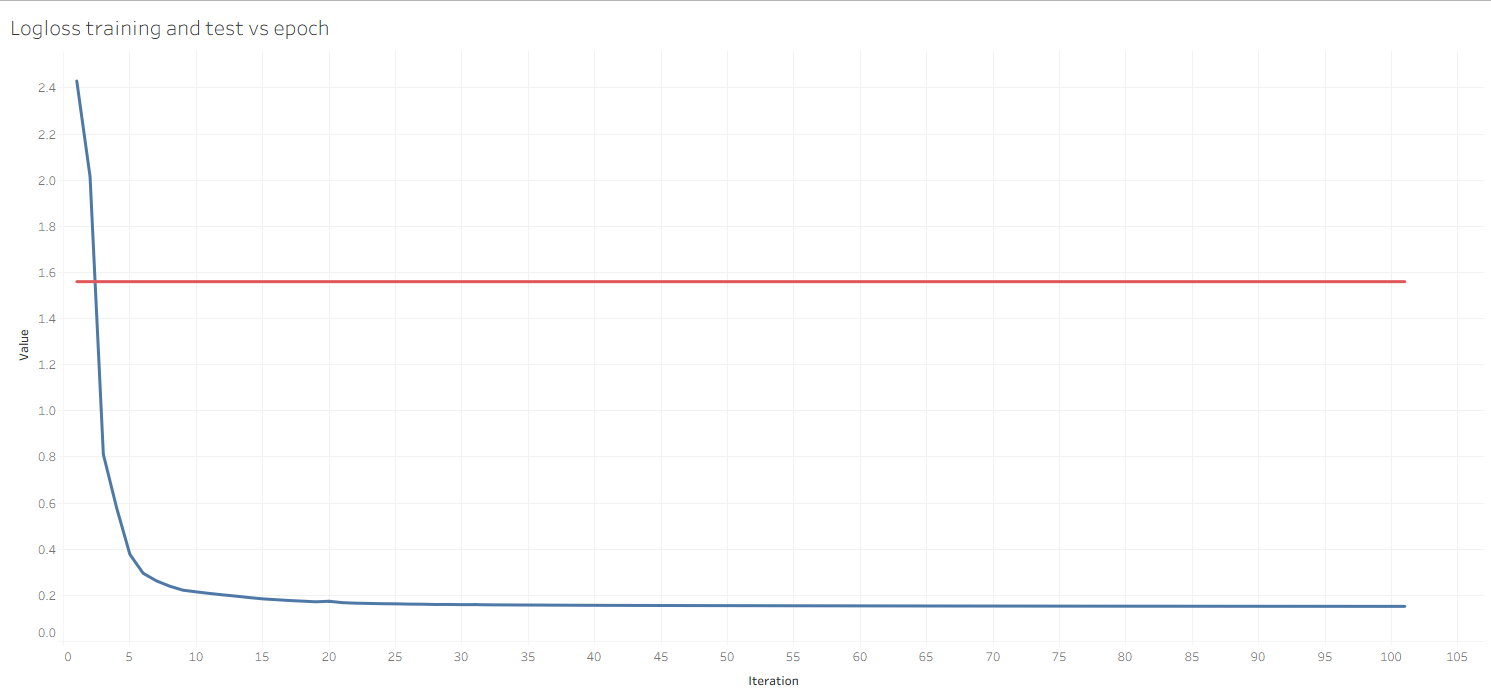

Podemos ver como la función de perdida descendió rápidamente en las primeras épocas y luego se estancó. Esto pudiera indicar que el modelo llegó a su límite de aprendizaje lo que podría sugerir que sería mejor opción un modelo más robusto. Por otra parte también vemos que la perdida de la validación está considerablemetne por encima de la de entrenamiento. Esto sugiere que hay un overfitting del modelo pues no está prediciendo correctamente los caso que no conoce.

Procedemos a generar una matriz de confusión para diagnósticar más precisamente los problemas y evaluar posibles mejoras del modelo.

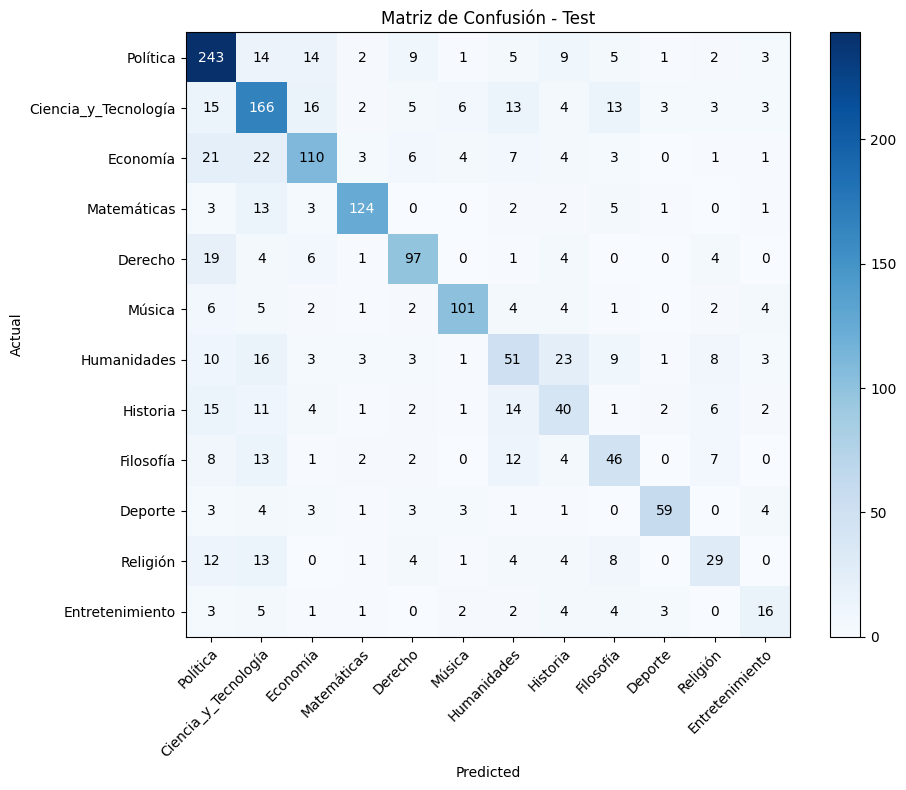

In [10]:
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

preds_pd = predictions.select('label', 'prediction').toPandas()

if 'preprocessing_model' in globals() and hasattr(preprocessing_model.stages[-1], 'labels'):
    label_names = preprocessing_model.stages[-1].labels

# Mapear índices a nombres legibles
preds_pd['actual'] = preds_pd['label'].astype(int).apply(lambda x: label_names[int(x)] if int(x) < len(label_names) else str(x))
preds_pd['predicted'] = preds_pd['prediction'].astype(int).apply(lambda x: label_names[int(x)] if int(x) < len(label_names) else str(x))
conf_matrix = pd.crosstab(preds_pd['actual'], preds_pd['predicted'])

# Asegurar orden consistente de filas/columnas con todas las etiquetas
labels_order = label_names
conf_matrix = conf_matrix.reindex(index=labels_order, columns=labels_order, fill_value=0)

# Visualizar la matriz con matplotlib
fig, ax = plt.subplots(figsize=(10,8))
im = ax.imshow(conf_matrix.values, interpolation='nearest', cmap='Blues')
ax.figure.colorbar(im, ax=ax)
ax.set(xticks=np.arange(len(labels_order)), yticks=np.arange(len(labels_order)), xticklabels=labels_order, yticklabels=labels_order, ylabel='Actual', xlabel='Predicted', title='Matriz de Confusión - Test')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')

# Anotar cada celda con el conteo
thresh = conf_matrix.values.max() / 2.
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(j, i, int(conf_matrix.values[i, j]), ha='center', va='center', color='white' if conf_matrix.values[i,j] > thresh else 'black')

plt.tight_layout()
plt.show()


Podemos ver que hay errores en todas las categorías por lo que aparentemente el modelo no tiene un problema de desbalance. Generemos ahora un gráfico que nos permita ver los falsos positivos y negativos en porcentaje para confirmar que no exista alguna clase particularmetne problemática. 

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Calcular FP y FN por categoría
preds_pd['actual_name'] = preds_pd['label'].astype(int).apply(lambda x: label_names[int(x)] if int(x) < len(label_names) else str(x))
preds_pd['pred_name'] = preds_pd['prediction'].astype(int).apply(lambda x: label_names[int(x)] if int(x) < len(label_names) else str(x))
rows = []
for lbl in label_names:
    total_actual = int((preds_pd['actual_name'] == lbl).sum())
    total_pred = int((preds_pd['pred_name'] == lbl).sum())
    fn = int(((preds_pd['actual_name'] == lbl) & (preds_pd['pred_name'] != lbl)).sum())
    fp = int(((preds_pd['actual_name'] != lbl) & (preds_pd['pred_name'] == lbl)).sum())

    fn_pct = (fn / total_actual * 100) if total_actual > 0 else 0.0
    fp_pct = (fp / total_actual * 100) if total_actual > 0 else 0.0
    rows.append({
        'category': lbl,
        'total_actual': total_actual,
        'total_predicted': total_pred,
        'false_negatives': fn,
        'false_positives': fp,
        'fn_pct': fn_pct,
        'fp_pct': fp_pct
    })

df_fpfn = pd.DataFrame(rows)

# Ordenar por tamaño para visualización
df_fpfn = df_fpfn.sort_values('total_actual', ascending=False).reset_index(drop=True)
labels = df_fpfn['category'].tolist()



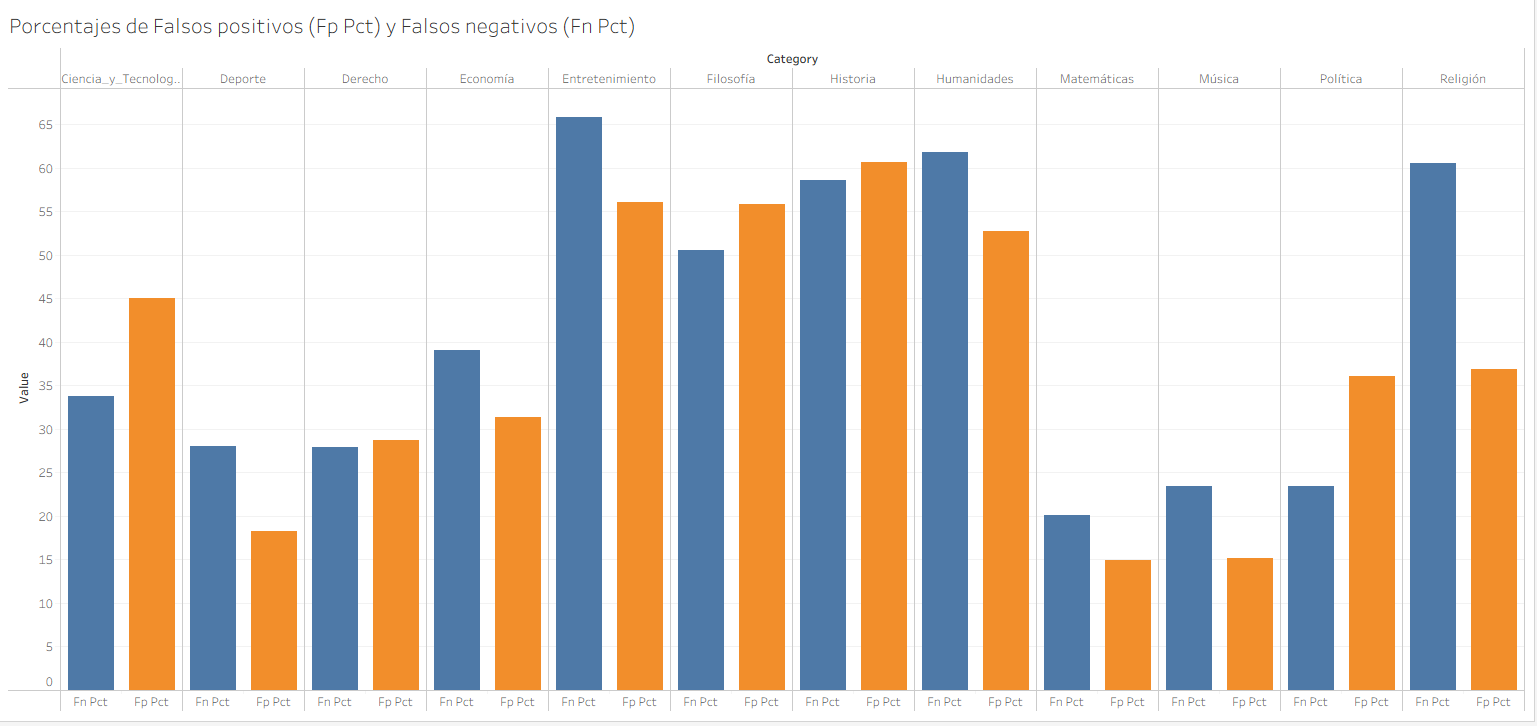

Podemos ver que el problema no es en particular una clase sino el desempeño general del modelo. Aunque hay clases como religión que tiene una diferencia marcarada entre falsos negativos y positivos que podrían estar diagnósticando un problema de desbalance, cuando vemos la gráfica del inicio de distribución de la cantidad de datos, religión no es de las que menos tiene por lo que se descarta esta teoría. El problema puede provenir de que el modelo no está encontrando el patrón de palabras que cartacterizan a estos temas o que en general los datos no son fáciles de categorizar en un solo tema.

Podemos concluir del modelo tiene un margen de mejora considerable pues solo tiene alrededor de un 64% de presición. En la imagen de abajo podemos analizar mejor el desempeño del modelo en cada uno de los temas que categoriza. Es posible que se requiera un modelo más robusto para aumentar la presición.

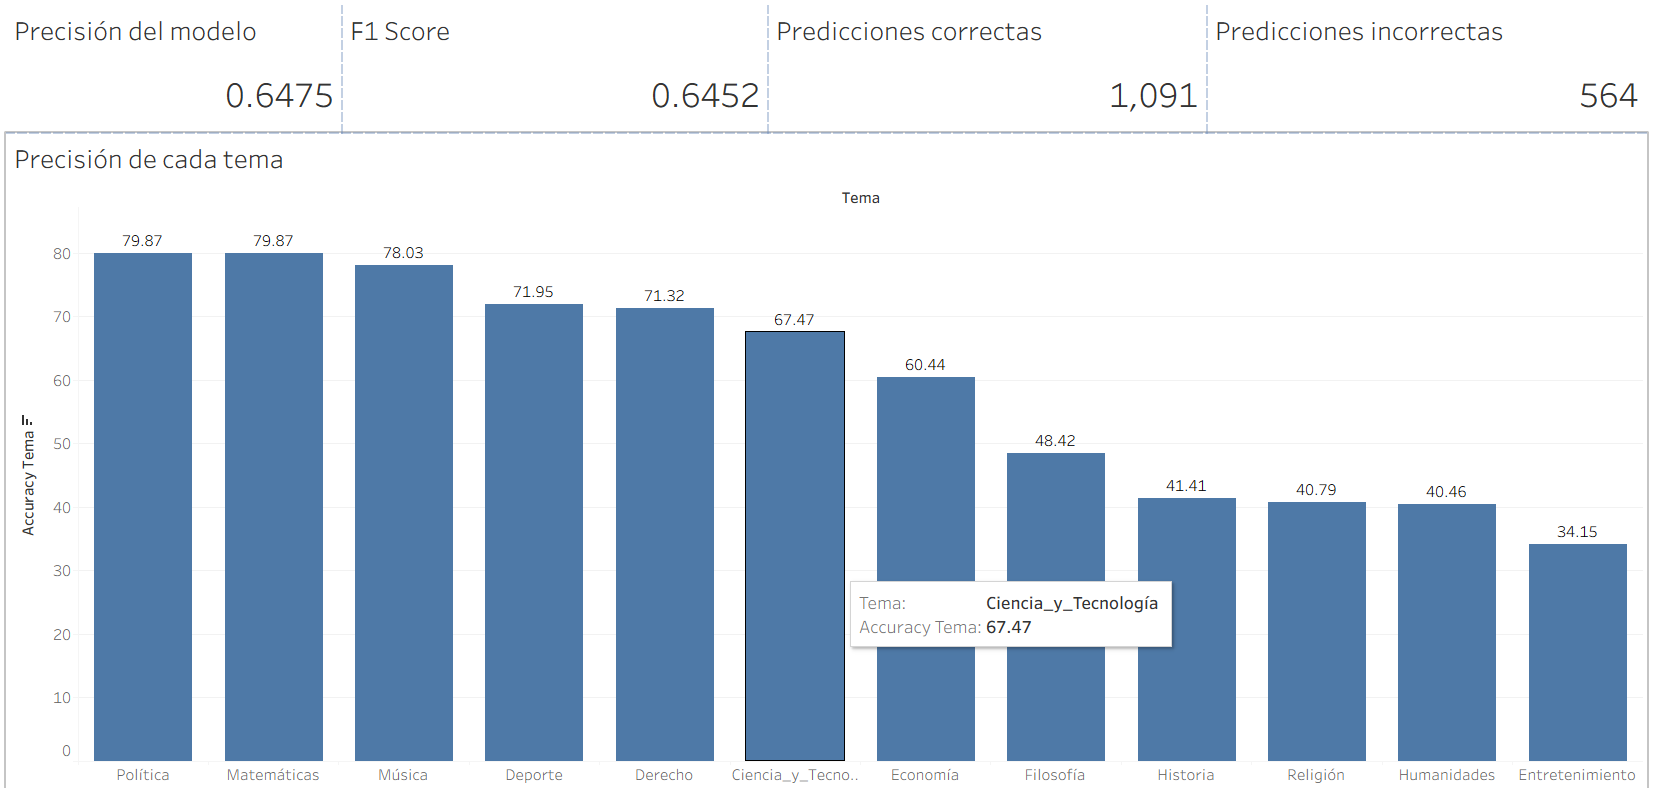

## Procesar información de CC-NEWS-ES



Los datos de CC-NEWS-ES vienen en archivos JSON de una sola línea. Son arreglos que contienen objetos con los atributos id, country y text. Por lo que necesitamos primero convertir a csv.

In [12]:
df = spark.read.option("multiline", "true").json("D:\\Tec\\Septimo\\Cloud\\Global Superstore Analysis\\CC-NEWS-ES\\ar\\ar.json")

# Selecciona solo las columnas que te interesan
df_simple = df.select("id", "text")

## Guardamos los resultados en un CSV. 
Posteriormente comentamos esta tarea para no hacerlo cada vez que corramos el archivo. 

In [13]:
# Save df_simple to CSV
'''
df_simple.coalesce(1) \
    .write.mode("overwrite") \
    .option("header", "true") \
    .csv("file:///D:\\Tec\\Septimo\\Cloud\\Global Superstore Analysis\\br_texts")
    '''

'\ndf_simple.coalesce(1)     .write.mode("overwrite")     .option("header", "true")     .csv("file:///D:\\Tec\\Septimo\\Cloud\\Global Superstore Analysis\\br_texts")\n    '

## Preparación de los datos
Limpiamos los textos tal como hicimos con el conjunto de datos de entrenamiento del modelo.

In [14]:
from pyspark.sql.functions import col, lower, trim, regexp_replace

df_prepared = (
    df_simple
    .withColumnRenamed("text", "texto")
    .withColumn("texto", lower(col("texto")))
    .withColumn("texto", trim(col("texto")))
    .withColumn("texto", regexp_replace(col("texto"), r'\s+', ' '))
    .filter(col("texto").isNotNull())
    .filter(col("texto") != "")
)


## División de los datos
Estuve lidiando con múltiples problemas de memoria por lo que manejar un solo archivo grande era dificil. Decidí dividirlo en lotes de 10,000 renglones cada uno

In [15]:
from pyspark.sql.functions import monotonically_increasing_id, floor

df_prepared.cache()
total_rows = df_prepared.count()
batch_size = 10000

# Calcular cuántos lotes necesitamos
num_batches = (total_rows // batch_size) + (1 if total_rows % batch_size > 0 else 0)
print(f"Número de lotes a crear: {num_batches}")

#Agregar ID y número de lote
df_with_batch = df_prepared.withColumn("row_id", monotonically_increasing_id()) \
                           .withColumn("batch_number", floor(col("row_id") / batch_size).cast("int"))

# Cachear para evitar recalcular
df_with_batch.cache()
df_with_batch.count()

Número de lotes a crear: 54


532703

## Preparamos los datos de cada lote para pasarlos por el modelo y guardamos los resultados.

In [16]:
output_dir = "clasificacion_resultados_spark"
os.makedirs(output_dir, exist_ok=True)

# Crear todos los subdirectorios 
for batch_num in range(num_batches):
    batch_dir = f"{output_dir}/lote_{batch_num + 1}"
    os.makedirs(batch_dir, exist_ok=True)

try:
    df_with_batch.drop("row_id") \
                 .write \
                 .partitionBy("batch_number") \
                 .mode("overwrite") \
                 .option("header", "true") \
                 .csv(f"{output_dir}/temp_parallel_output")
    
    import glob
    import shutil
    
    files_moved = 0
    total_size = 0
    
    for batch_num in range(num_batches):
        partition_dir = f"{output_dir}/temp_parallel_output/batch_number={batch_num}"
        
        if os.path.exists(partition_dir):
            # Buscar archivos CSV en la partición
            csv_files = glob.glob(f"{partition_dir}/*.csv")
            
            if csv_files:
                # Mover el primer archivo CSV encontrado
                source_file = csv_files[0]
                dest_file = f"{output_dir}/lote_{batch_num + 1}/articulos_lote_{batch_num + 1}.csv"
                
                shutil.move(source_file, dest_file)
                
                # Calcular tamaño
                file_size = os.path.getsize(dest_file) / (1024 * 1024)
                total_size += file_size
                files_moved += 1
                
                print(f"Lote {batch_num + 1}: {file_size:.2f} MB")
    
    # Limpiar directorio temporal
    if os.path.exists(f"{output_dir}/temp_parallel_output"):
        shutil.rmtree(f"{output_dir}/temp_parallel_output")
    
except Exception as e:
    print(f"❌ Error en procesamiento paralelo: {e}")
    import traceback
    traceback.print_exc()

Lote 1: 15.92 MB
Lote 2: 15.51 MB
Lote 3: 15.42 MB
Lote 4: 16.65 MB
Lote 5: 16.19 MB
Lote 6: 16.56 MB
Lote 5: 16.19 MB
Lote 6: 16.56 MB
Lote 7: 15.99 MB
Lote 8: 17.02 MB
Lote 7: 15.99 MB
Lote 8: 17.02 MB
Lote 9: 15.88 MB
Lote 10: 16.41 MB
Lote 9: 15.88 MB
Lote 10: 16.41 MB
Lote 11: 16.32 MB
Lote 11: 16.32 MB
Lote 12: 16.37 MB
Lote 13: 16.55 MB
Lote 14: 16.56 MB
Lote 12: 16.37 MB
Lote 13: 16.55 MB
Lote 14: 16.56 MB
Lote 15: 15.25 MB
Lote 16: 15.77 MB
Lote 15: 15.25 MB
Lote 16: 15.77 MB
Lote 17: 15.74 MB
Lote 17: 15.74 MB
Lote 18: 16.38 MB
Lote 19: 16.50 MB
Lote 20: 16.36 MB
Lote 18: 16.38 MB
Lote 19: 16.50 MB
Lote 20: 16.36 MB
Lote 21: 16.81 MB
Lote 22: 15.99 MB
Lote 21: 16.81 MB
Lote 22: 15.99 MB
Lote 23: 17.43 MB
Lote 24: 15.94 MB
Lote 23: 17.43 MB
Lote 24: 15.94 MB
Lote 25: 16.11 MB
Lote 26: 17.91 MB
Lote 25: 16.11 MB
Lote 26: 17.91 MB
Lote 27: 16.25 MB
Lote 28: 15.52 MB
Lote 27: 16.25 MB
Lote 28: 15.52 MB
Lote 29: 15.26 MB
Lote 30: 16.46 MB
Lote 29: 15.26 MB
Lote 30: 16.46 MB
Lote 3

## Cargar modelos entrenados

Cargamos el modelo de preprocesamiento y clasificación que entrenamos anteriormente para poder clasificar los nuevos textos.

In [17]:
from pyspark.ml import PipelineModel
from pyspark.ml.classification import LogisticRegressionModel
import pickle

preprocessing_model_loaded = PipelineModel.load("modelo_preprocessing_wikicat_mejorado")
modelo_clasificacion_loaded = LogisticRegressionModel.load("modelo_clasificacion_wikicat_mejorado")

with open("label_to_tema_mapping.pkl", "rb") as f:
    label_to_tema_loaded = pickle.load(f)

index_to_label_loaded = {v: k for k, v in label_to_tema_loaded.items()} if isinstance(label_to_tema_loaded, dict) else {}

for i in sorted(index_to_label_loaded.keys()):
    print(f"   {i:2d}: {index_to_label_loaded[i]}")


    0: Política
    1: Ciencia_y_Tecnología
    2: Economía
    3: Matemáticas
    4: Derecho
    5: Música
    6: Humanidades
    7: Historia
    8: Filosofía
    9: Deporte
   10: Religión
   11: Entretenimiento


## Clasificar artículos por lotes

Procesamos cada lote de artículos usando el modelo entrenado. Utilizamos Spark para procesar los lotes de forma eficiente y guardamos los resultados con las predicciones. Para leer los csvs tuve que utilizar pandas debido a un problema con las librerías de hadoop en la que no encontraba una función en especifico y no encontré alternativas. Inmediatamente después los convertimos a dataframes de Pyspark

In [18]:
import pandas as pd
from pyspark.sql.functions import col

input_dir = "clasificacion_resultados"
output_dir = "clasificacion_resultados_predicciones"
os.makedirs(output_dir, exist_ok=True)

csv_files = []
for i in range(1, num_batches + 1):
    csv_path = f"{input_dir}/lote_{i}/articulos_lote_{i}.csv"
    if os.path.exists(csv_path):
        csv_files.append((i, csv_path))

resultados_resumen = []

for batch_num, csv_file in csv_files:
    try:
        pandas_input = pd.read_csv(csv_file)
        num_docs = len(pandas_input)
        df_lote = spark.createDataFrame(pandas_input)
        
        df_procesado = preprocessing_model_loaded.transform(df_lote)
        df_predicciones = modelo_clasificacion_loaded.transform(df_procesado)
        
        df_resultado = df_predicciones.select(
            "id",
            "texto",
            col("prediction").alias("tema_id")
        )
        
        pandas_resultado = df_resultado.toPandas()

        # Usar el mapeo índice->nombre seguro (index_to_label_loaded)
        pandas_resultado['tema_predicho'] = pandas_resultado['tema_id'].apply(
            lambda x: index_to_label_loaded.get(int(x), "Desconocido") if pd.notna(x) else "Desconocido"
        )

        batch_output_dir = f"{output_dir}/lote_{batch_num}"
        os.makedirs(batch_output_dir, exist_ok=True)
        
        output_csv = f"{batch_output_dir}/predicciones_lote_{batch_num}.csv"
        pandas_resultado.to_csv(output_csv, index=False, encoding='utf-8')
        
        # 8. Calcular estadísticas
        tema_counts = pandas_resultado['tema_predicho'].value_counts()
        
        stats_file = f"{batch_output_dir}/estadisticas_lote_{batch_num}.txt"
        with open(stats_file, 'w', encoding='utf-8') as f:
            f.write(f"ESTADÍSTICAS - LOTE {batch_num}\n")
            f.write(f"{'='*50}\n\n")
            f.write(f"Total de documentos: {num_docs:,}\n\n")
            f.write(f"Distribución por tema:\n")
            f.write(f"{'-'*50}\n\n")
            for tema, count in tema_counts.items():
                porcentaje = (count / num_docs) * 100
                f.write(f"{tema:30s}: {count:6,} ({porcentaje:5.2f}%)\n")
        
        resultados_resumen.append({
            'lote': batch_num,
            'documentos': num_docs,
            'tamaño_mb': file_size,
            'temas_unicos': len(tema_counts)
        })
        
        print(f"LOTE {batch_num} COMPLETADO:")
        del pandas_input, df_lote, df_procesado, df_predicciones, df_resultado, pandas_resultado
        
    except Exception as e:
        print(f"Error al procesar lote {batch_num}: {e}")
        import traceback
        traceback.print_exc()
        break

print(f"Total de lotes procesados: {len(csv_files)}/{num_batches}")

# Crear DataFrame de resumen
if resultados_resumen:
    df_resumen = pd.DataFrame(resultados_resumen)
    print(df_resumen.to_string(index=False))
    
    # Guardar resumen general
    resumen_csv = f"{output_dir}/resumen_clasificacion.csv"
    df_resumen.to_csv(resumen_csv, index=False)
    print(f"Resumen guardado en: {resumen_csv}")
    
    # Estadísticas globales
    total_docs = df_resumen['documentos'].sum()
    total_size = df_resumen['tamaño_mb'].sum()
    
    print(f"   • Documentos clasificados: {total_docs:,}")

print(f"Resultados guardados en: {os.path.abspath(output_dir)}")

LOTE 1 COMPLETADO:
LOTE 2 COMPLETADO:
LOTE 2 COMPLETADO:
LOTE 3 COMPLETADO:
LOTE 3 COMPLETADO:
LOTE 4 COMPLETADO:
LOTE 4 COMPLETADO:
LOTE 5 COMPLETADO:
LOTE 5 COMPLETADO:
LOTE 6 COMPLETADO:
LOTE 6 COMPLETADO:
LOTE 7 COMPLETADO:
LOTE 7 COMPLETADO:
LOTE 8 COMPLETADO:
LOTE 8 COMPLETADO:
LOTE 9 COMPLETADO:
LOTE 9 COMPLETADO:
LOTE 10 COMPLETADO:
LOTE 10 COMPLETADO:
LOTE 11 COMPLETADO:
LOTE 11 COMPLETADO:
LOTE 12 COMPLETADO:
LOTE 12 COMPLETADO:
LOTE 13 COMPLETADO:
LOTE 13 COMPLETADO:
LOTE 14 COMPLETADO:
LOTE 14 COMPLETADO:
LOTE 15 COMPLETADO:
LOTE 15 COMPLETADO:
LOTE 16 COMPLETADO:
LOTE 16 COMPLETADO:
LOTE 17 COMPLETADO:
LOTE 17 COMPLETADO:
LOTE 18 COMPLETADO:
LOTE 18 COMPLETADO:
LOTE 19 COMPLETADO:
LOTE 19 COMPLETADO:
LOTE 20 COMPLETADO:
LOTE 20 COMPLETADO:
LOTE 21 COMPLETADO:
LOTE 21 COMPLETADO:
LOTE 22 COMPLETADO:
LOTE 22 COMPLETADO:
LOTE 23 COMPLETADO:
LOTE 23 COMPLETADO:
LOTE 24 COMPLETADO:
LOTE 24 COMPLETADO:
LOTE 25 COMPLETADO:
LOTE 25 COMPLETADO:
LOTE 26 COMPLETADO:
LOTE 26 COMPLETAD

## Análisis consolidado de resultados

Consolidamos todos los resultados de los lotes para obtener estadísticas generales de la clasificación.

In [19]:
import glob
prediction_files = glob.glob(f"{output_dir}/lote_*/predicciones_lote_*.csv")

if prediction_files:
    all_predictions = []
    
    for file in sorted(prediction_files):
        df = pd.read_csv(file)
        all_predictions.append(df)
    
    df_consolidado = pd.concat(all_predictions, ignore_index=True)
    total_docs = len(df_consolidado)
    tema_distribution = df_consolidado['tema_predicho'].value_counts()
    
    for i, (tema, count) in enumerate(tema_distribution.items(), 1):
        porcentaje = (count / total_docs) * 100
        barra = "█" * int(porcentaje / 2)
        print(f"{i:2d}. {tema:30s}: {count:8,} ({porcentaje:5.2f}%) {barra}")
    
    consolidado_csv = f"{output_dir}/predicciones_consolidadas.csv"
    df_consolidado.to_csv(consolidado_csv, index=False, encoding='utf-8')
    
    stats_global_file = f"{output_dir}/estadisticas_globales.txt"
    with open(stats_global_file, 'w', encoding='utf-8') as f:
        f.write("ESTADÍSTICAS GLOBALES DE CLASIFICACIÓN\n")
        f.write("="*60 + "\n\n")
        f.write(f"Total de documentos clasificados: {total_docs:,}\n")
        f.write(f"Total de temas únicos: {len(tema_distribution)}\n\n")
        f.write("Distribución por tema:\n")
        f.write("-"*60 + "\n\n")
        
        for i, (tema, count) in enumerate(tema_distribution.items(), 1):
            porcentaje = (count / total_docs) * 100
            f.write(f"{i:2d}. {tema:30s}: {count:8,} ({porcentaje:5.2f}%)\n")
else:
    print("\n⚠️  No se encontraron archivos de predicciones para consolidar.")

 1. Política                      :  150,502 (28.25%) ██████████████
 2. Derecho                       :   62,340 (11.70%) █████
 3. Ciencia_y_Tecnología          :   61,845 (11.61%) █████
 4. Economía                      :   58,491 (10.98%) █████
 5. Deporte                       :   50,623 ( 9.50%) ████
 6. Humanidades                   :   42,787 ( 8.03%) ████
 7. Historia                      :   34,590 ( 6.49%) ███
 8. Música                        :   21,634 ( 4.06%) ██
 9. Religión                      :   15,949 ( 2.99%) █
10. Filosofía                     :   12,532 ( 2.35%) █
11. Matemáticas                   :   11,740 ( 2.20%) █
12. Entretenimiento               :    9,670 ( 1.82%) 


Podemos ver que el modelo identifica que el dataset de CC-NEWS contiene principalmente noticias de política, ciencia y economía con casi el 50% de las predicciones. Las categoría con menos textos fue entretenimiento con un 1.66% de los textos seguida de filosofía y matemáticas. 

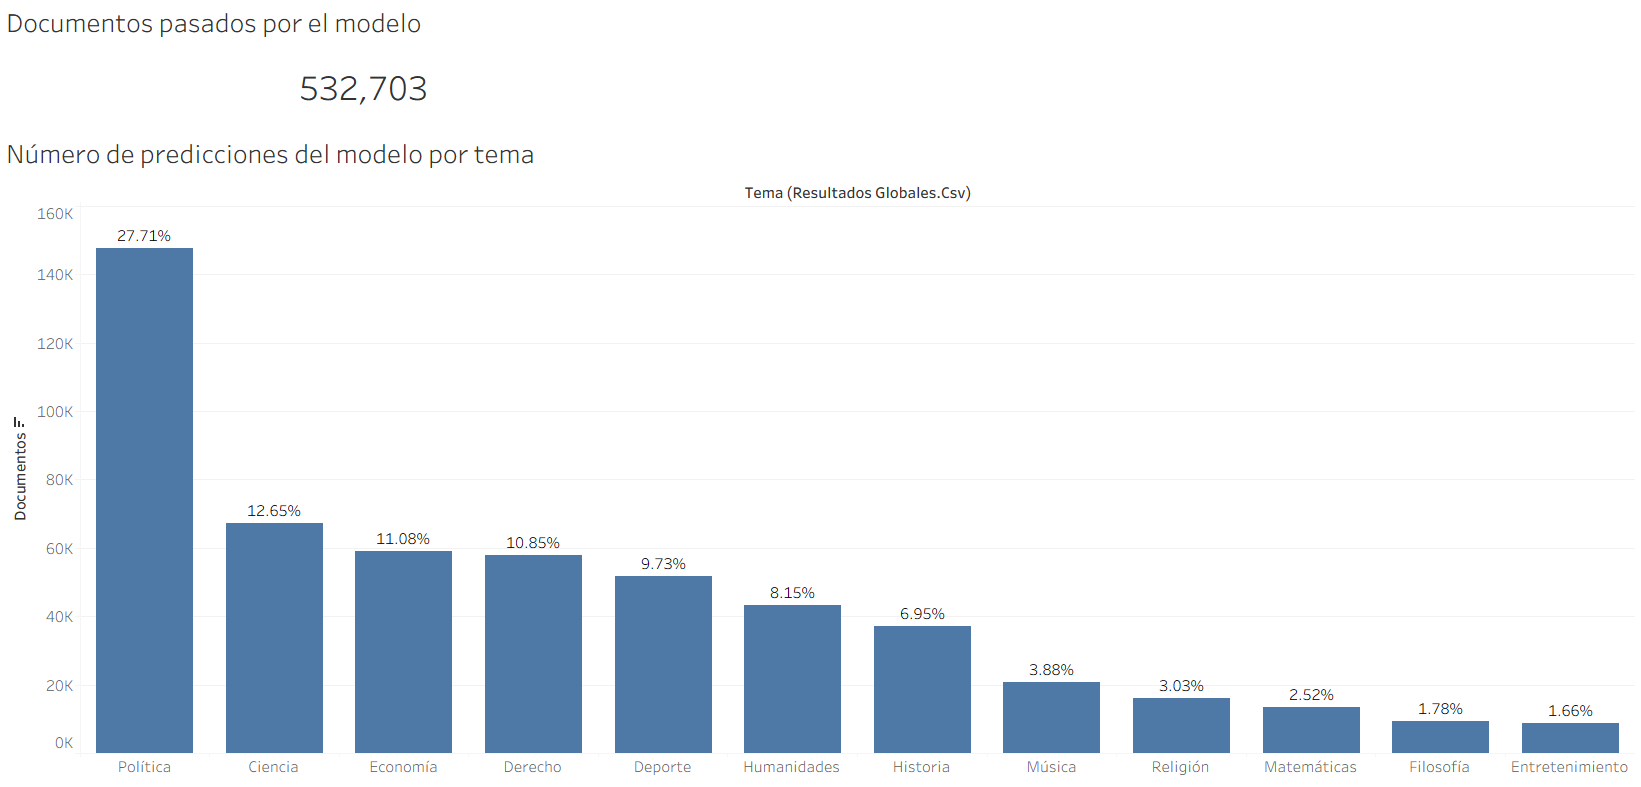

## Versiones que se usaron para este trabajo.

In [20]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
print("🔹 Spark version:", spark.version)
print("🔹 Hadoop version:", spark._jvm.org.apache.hadoop.util.VersionInfo.getVersion())


🔹 Spark version: 4.0.1
🔹 Hadoop version: 3.4.1
🔹 Hadoop version: 3.4.1


## Link de Tablue Public

https://public.tableau.com/app/profile/imanol.mu.iz.ramirez/viz/NLP_17622915284760/Story1?publish=yes